In [211]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn import preprocessing

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Воспользуемся публичными данными листинга Airbnb за март 2022 года.

In [244]:
melb = pd.read_csv("listings_melb.csv")
sydney = pd.read_csv("listings_sydney.csv")

Для того, чтобы продемонстрировать, что такое **дрейф данных** возьмем в качестве обучающей выборки листиг Мельбурна, а в качестве тестовой листинг Сиднея. Возьмем только некоторые колонки.

In [245]:
feats = [
         "number_of_reviews",
         "minimum_nights",
         "license",
         "price",
         "neighbourhood",
]

cat_feats = ["license", "neighbourhood"]


melb = melb[feats]
sydney = sydney[feats]

## Состязательная валидация (Adversarial Validation)

Сперва попробуем определить наличие дрейфа данных с помощью состязательной валидации.

In [230]:
def adv_val(
    train,
    test,
    feats,
    cat_feats,
):
    target = np.hstack([np.zeros(train.shape[0]), np.ones(test.shape[0])])
    train = pd.concat([train, test], axis=0)
    train = train[feats]

    for col in cat_feats:
        if train[col].dtype == object:
            encoder = preprocessing.LabelEncoder()
            train[col] = encoder.fit_transform(train[col].to_list())

    train, test, y_train, y_test = model_selection.train_test_split(
        train, target, test_size=0.33, random_state=1, shuffle=True
    )

    train = lgb.Dataset(train, label=y_train, categorical_feature=cat_feats)

    test = lgb.Dataset(test, label=y_test, categorical_feature=cat_feats)

    param = {
        "objective": "binary",
        "learning_rate": 0.01,
        "boosting": "gbdt",
        "metric": "auc",
        "verbosity": -1,
    }

    clf = lgb.train(
        param,
        train,
        num_boost_round=200,
        valid_sets=[train, test],
        verbose_eval=50,
        early_stopping_rounds=50,
    )

    feature_imp = pd.DataFrame(
        sorted(
            zip(
                clf.feature_importance(
                    importance_type="gain",
                ),
                clf.feature_name(),
            )
        ),
        columns=["Feature Split Total Gain", "Feature"],
    )

    plt.figure(figsize=(8, 8))
    sns.barplot(
        x="Feature Split Total Gain",
        y="Feature",
        data=feature_imp.sort_values(
            by="Feature Split Total Gain", ascending=False
        ).head(100),
    )

    plt.title("LightGBM - Feature Importance")
    plt.tight_layout()
    plt.show()

    return clf, feature_imp

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 1	valid_1's auc: 1
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[52]	training's auc: 1	valid_1's auc: 1


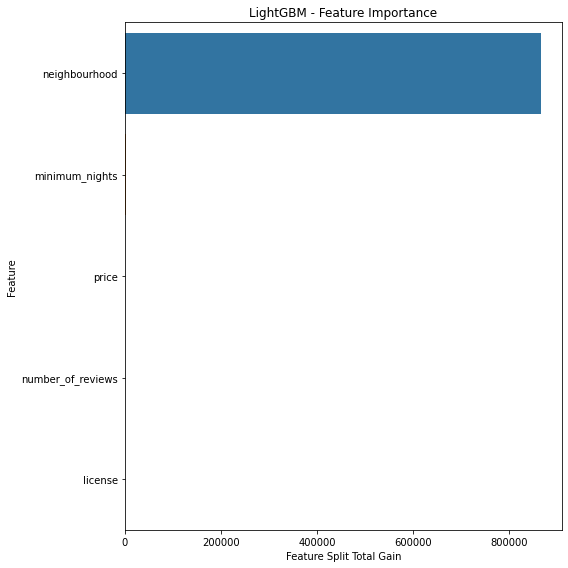

In [231]:
clf, feature_imp = adv_val(melb, sydney, feats, cat_feats)

Сразу получаем значение `ROC AUC` равное 1, потому что название районов для двух этих городов, очевидно, разные. Попробуем удалить этот признак и провести состязательную валидацию еще раз

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.999107	valid_1's auc: 0.997688
Early stopping, best iteration is:
[5]	training's auc: 0.999122	valid_1's auc: 0.997571


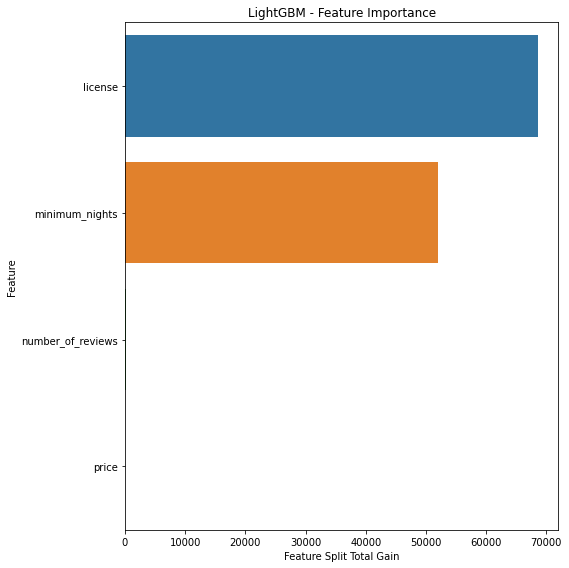

In [233]:
feats = [
         "number_of_reviews",
         "minimum_nights",
         "license",
         "price",
]

cat_feats = ["license"]


melb = melb[feats]
sydney = sydney[feats]

clf, feature_imp = adv_val(melb, sydney, feats, cat_feats)

Аналогично с `license`.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.888765	valid_1's auc: 0.884264
[100]	training's auc: 0.891075	valid_1's auc: 0.884825
Early stopping, best iteration is:
[90]	training's auc: 0.890697	valid_1's auc: 0.884894


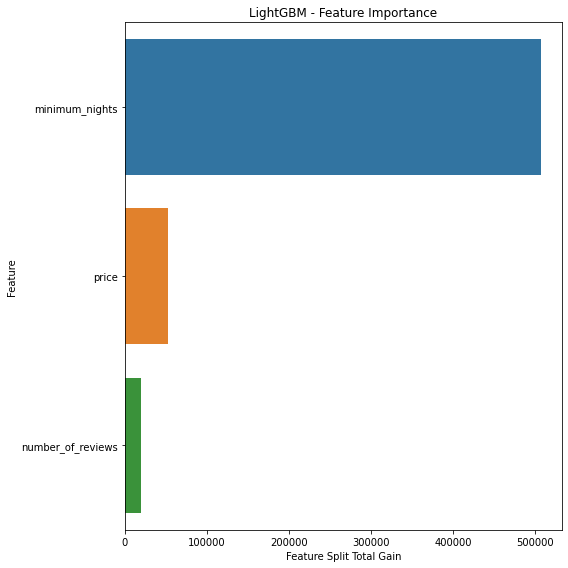

In [234]:
feats = [
         "number_of_reviews",
         "minimum_nights",
         "price",
]

cat_feats = []


melb = melb[feats]
sydney = sydney[feats]

clf, feature_imp = adv_val(melb, sydney, feats, cat_feats)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.616182	valid_1's auc: 0.597821
[100]	training's auc: 0.620458	valid_1's auc: 0.599475
[150]	training's auc: 0.624283	valid_1's auc: 0.600226
[200]	training's auc: 0.627574	valid_1's auc: 0.600418
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.627574	valid_1's auc: 0.600418


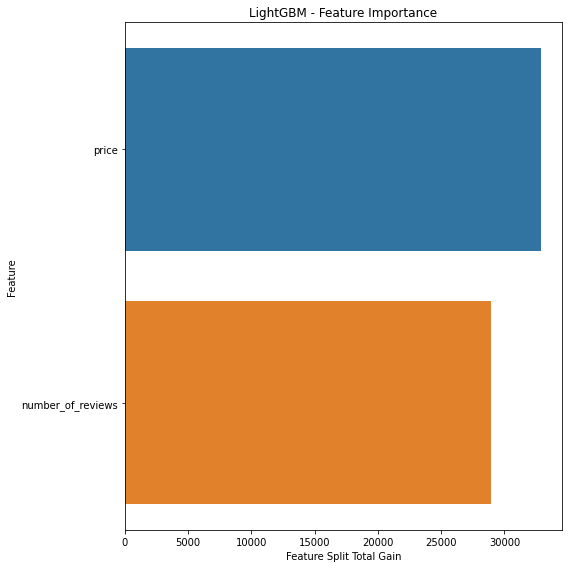

In [238]:
feats = [
         "number_of_reviews",
         "price",
]

cat_feats = []


melb = melb[feats]
sydney = sydney[feats]

clf, feature_imp = adv_val(melb, sydney, feats, cat_feats)

## Индекс стабильности популяции

Видим, что признак `price` все таки значительно разделяет эти две выборки, посмотрим на значения индекса стабильности популяции по каждому из признаков. Для этого воспользуемся реализованным на `PySpark` методом.

In [248]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

from pyspark.ml.feature import Bucketizer, QuantileDiscretizer
from pyspark.sql.types import StructType,StructField, StringType, IntegerType

In [240]:
spark = (SparkSession
    .builder
    .getOrCreate())

In [241]:
def psi(actual, expected, column, num_buckets):
  output_col = column + "_bucket"

  qd = QuantileDiscretizer(
      relativeError=0,
      handleInvalid="keep",
      numBuckets=num_buckets,
      inputCol=column,
      outputCol=output_col,
  )

  bucketizer = qd.fit(expected)

  ref_size = expected.count()
  actual_size = actual.count()

  ref_histogram = (
      bucketizer.transform(expected.select(F.col(column)))
      .groupBy(output_col)
      .agg((F.count(F.lit(1)) / ref_size * 100).alias("ref_ratio"))
  )

  actual_histogram = (
      bucketizer.transform(actual.select(F.col(column)))
      .groupBy(output_col)
      .agg((F.count(F.lit(1)) / actual_size * 100).alias("actual_ratio"))
  )

  joined_df = actual_histogram.join(
      ref_histogram,
      actual_histogram[output_col].eqNullSafe(ref_histogram[output_col]),
      how="outer"
  ).fillna(0.001)

  return get_psi_score(joined_df), joined_df


def psi_categorical(actual, expected, column, eps):
  binned_ref_df = expected.groupBy(column).count()
  binned_df = actual.groupBy(column).count()

  ref_size = binned_ref_df.groupBy().sum("count").collect()[0][0]
  actual_size = binned_df.groupBy().sum("count").collect()[0][0]

  ref_histogram = binned_ref_df.withColumn(
      "ref_ratio",
      (F.col("count") / ref_size * 100)
      ).drop("count")

  actual_histogram = binned_df.withColumn(
      "actual_ratio",
      (F.col("count") / actual_size * 100)
      ).drop("count")

  joined_df = actual_histogram.join(
      ref_histogram.withColumnRenamed(column, f'{column}_ref'),
      F.col(column).eqNullSafe(F.col(f'{column}_ref')),
      how="outer").drop(column, f'{column}_ref').fillna(eps)

  return get_psi_score(joined_df), joined_df



def get_psi_score(df):
  res = (
      df.withColumn("psi",
                    (F.col("actual_ratio") - F.col("ref_ratio"))
                    * F.log(F.col("actual_ratio") / F.col("ref_ratio"))
                    ).agg(F.sum("psi").alias("psi")).select("psi").first()[0]
  )

  return res if res is not None else float("inf")

In [247]:
melb.columns

Index(['number_of_reviews', 'minimum_nights', 'license', 'price',
       'neighbourhood'],
      dtype='object')

In [251]:
schema = StructType([
    StructField("number_of_reviews", IntegerType(),True),
    StructField("minimum_nights", IntegerType(),True),
    StructField("license",StringType(),True),
    StructField("price", IntegerType(), True),
    StructField("neighbourhood", StringType(), True),
  ])

melb_sdf = spark.createDataFrame(melb, schema)
sydney_sdf = spark.createDataFrame(sydney, schema)

In [254]:
for feat in feats:
  if feat in cat_feats:
    psi_val, joined_df = psi_categorical(
          actual=sydney_sdf,
          expected=melb_sdf,
          column=feat,
          eps=0.01
      )

    print(f'For feat {feat} categorical psi = {psi_val}')
    joined_df.show(10, False)
    continue

  psi_val, joined_df = psi(
      actual=sydney_sdf,
      expected=melb_sdf,
      column=feat,
      num_buckets=10,
  )

  print(f'For feat {feat} psi = {psi_val}')
  joined_df.show(10, False)

For feat number_of_reviews psi = 7.023053335039197
+------------------------+------------------+------------------------+------------------+
|number_of_reviews_bucket|actual_ratio      |number_of_reviews_bucket|ref_ratio         |
+------------------------+------------------+------------------------+------------------+
|1.0                     |25.90110573931358 |1.0                     |21.802124220734242|
|2.0                     |22.598248049399263|2.0                     |16.52043407988917 |
|3.0                     |12.9768799961706  |3.0                     |11.371507734934196|
|4.0                     |9.329376286439137 |4.0                     |9.761025167397829 |
|5.0                     |8.419893734143889 |5.0                     |10.176633571923343|
|6.0                     |7.874204202766742 |6.0                     |10.245901639344263|
|7.0                     |6.658369632856253 |7.0                     |10.10159316555068 |
|8.0                     |6.241922358910536 |8.0 

На этом примере можно проследить зависимость индекса от подбора $\varepsilon = [0.01, 0.001, 0.0001, 0.00001, 10^{-14}]$. Эта разница может стать критической при росте числа мелких категорий.

In [255]:
for epsilon in [0.01, 0.001, 0.0001, 0.00001, 1e-14]:
  psi_val, joined_df = psi_categorical(
      actual=sydney_sdf,
      expected=melb_sdf,
      column='license',
      eps=epsilon
  )

  print(f'For eps = {epsilon}, psi is {psi_val}')

For eps = 0.01, psi is 82.84080384669933
For eps = 0.001, psi is 125.38958750478292
For eps = 0.0001, psi is 221.19536249524958
For eps = 1e-05, psi is 311.73683331087545
For eps = 1e-14, psi is 1109.9346226132222


## Насколько на самом деле отличаются распределения?

Посмотрим на распределния наших признаков на разных датасетах 

In [209]:
def plot_pairwise_dist_plot(df_1, df_1_name, df_2, df_2_name, col_name, xlim=None, ylim=None):
    fig = plt.figure(figsize=(10, 8))

    
    sns.distplot(df_1[col_name], color='dodgerblue', label='{}_{}'.format(df_1_name, col_name), kde_kws={'linewidth':3}, hist_kws={'alpha':.7}, bins=100)
    sns.distplot(df_2[col_name], color='orange', label='{}_{}'.format(df_2_name, col_name), kde_kws={'linewidth':3}, hist_kws={'alpha':.7}, bins=100)
    
    if not xlim is None:
        plt.xlim(xlim)
    if not ylim is None:
        plt.ylim(ylim)
    
    plt.title('{} distribution'.format(col_name))
    plt.legend()
    plt.show()



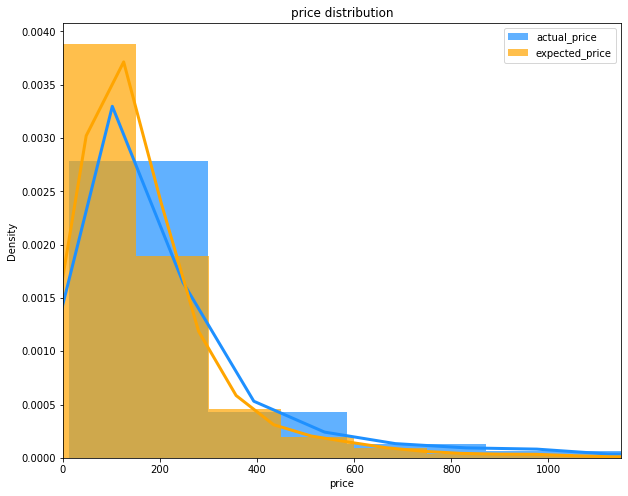

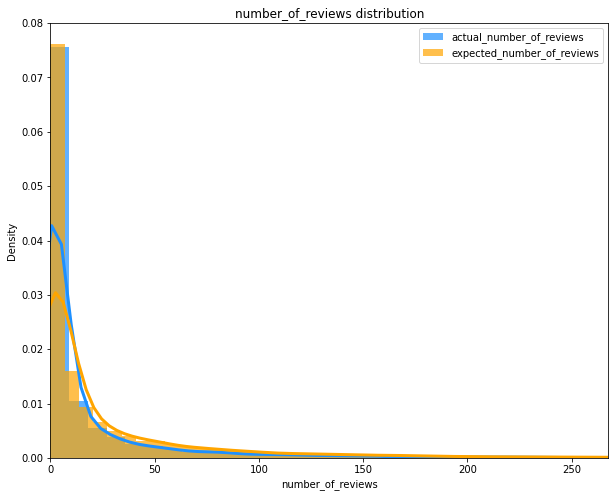

In [256]:
for feat in ['price', 'number_of_reviews']:
  xlim_t = np.quantile(melb.fillna(0)[feat], 0.99)
  plot_pairwise_dist_plot(sydney, 'actual', melb, 'expected', feat, [0, xlim_t])

In [257]:
spark.stop()